## Imports

In [1]:
import os
import time
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from numpy import cos, exp, sin, sqrt, tanh
from PIL import Image as im
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

## Functions

In [2]:
class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end = time.time()
        self.elapsed = divmod(self.end-self.start, 60)
        self.mins = int(self.elapsed[0])
        self.secs = float(f'{self.elapsed[1]:.2f}')

In [3]:
def random_kernel(kernel_size=3, seed=None, dim=2):
    assert kernel_size % 2 == 1, 'Kernel side length must be an odd number.'

    np.random.seed(seed)
    
    size = np.zeros((kernel_size,)*dim).shape

    kernel = np.random.randint(1, 13, size=size)

    return kernel

In [4]:
def random_func(x, f_key):
    functions = [
        lambda x: x,  # Placeholder for 0, not used
        lambda x: sin(x),
        lambda x: cos(x),
        lambda x: sin(3 * x),
        lambda x: cos(3 * x),
        lambda x: sqrt(np.maximum(0, x)),
        lambda x: exp(-x),
        lambda x: sqrt(0.5 * x),
        lambda x: x ** 2,
        lambda x: x,
        lambda x: tanh(x),
        lambda x: exp(-2 * x),
        lambda x: 1 / (1 + exp(-x)),
    ]
    return functions[f_key](x)


In [5]:
functions = [
        lambda x: x,  # Placeholder for 0, not used
        lambda x: sin(x),
        lambda x: cos(x),
        lambda x: sin(3 * x),
        lambda x: cos(3 * x),
        lambda x: sqrt(max(0, x)),
        lambda x: exp(-x),
        lambda x: sqrt(0.5 * x),
        lambda x: x ** 2,
        lambda x: x,
        lambda x: tanh(x),
        lambda x: exp(-2 * x),
        lambda x: 1 / (1 + exp(-x)),
    ]

In [6]:
def conv(img, kernel, resize=0):
    if resize:
        img.thumbnail((resize, resize), im.BILINEAR)
    print(f'Resized to: {img.size[0]}x{img.size[1]}')

    img = np.array(img)
    rgb = np.transpose(img, (2, 0, 1))/255

    im_new = np.zeros(img.shape, 'uint8')
    
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2
    
    kernel_flat = kernel.flatten()
    kernel_results = np.zeros_like(kernel_flat)

    
    func_list = [functions[i] for i in kernel_flat]
    

    for idx, channel in enumerate(rgb):
        padded = np.pad(channel, pad_size, mode='edge')
        padded_h, padded_w = padded.shape
        for h in range(padded_h-kernel_size+1):
            for w in range(padded_w-kernel_size+1):
                
                window = padded[h:h+kernel_size, w:w+kernel_size].flatten()
                kernel_results = []

                for i in range(len(kernel_flat)):
                    kernel_results.append(func_list[i](window[i]))
                kernel_results = np.array(kernel_results)

                result = (kernel_results.mean()*255).clip(0, 255).astype('uint8')
                im_new[h, w, idx] = result
    final_image = im.fromarray(im_new)
    return final_image


## Classes

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, data_count, do_convolution=False, resize=None, kernel_size=3, seed=None, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.do_convolution = do_convolution
        self.resize = resize
        self.kernel_size = kernel_size
        self.seed = seed
        self.image_filenames = [f for f in os.listdir(image_dir) if (f.startswith('IMG') and f.endswith('.JPEG'))]
        self.kernel = random_kernel(kernel_size=self.kernel_size, seed=self.seed)
        kernel_ext = f'{self.kernel.flatten()}'.replace("  ","_").replace(" ","_")

        if len(self.image_filenames) == 0:
            print(f"No images found in the directory: {image_dir}. Please check the directory path and file extensions.")
        else:
            print(f"Found {len(self.image_filenames)} images in /{image_dir} folder")
        
        if data_count and data_count <= len(os.listdir(image_dir)):
            # self.image_filenames = self.image_filenames[:data_count]
            random.seed(seed)
            self.image_filenames = random.sample(self.image_filenames, data_count)

        print(f"Selected {len(self.image_filenames)} images to be evaluated.")
        print(f'Kernel variation {kernel_ext}x{resize} initiated.')


    def __len__(self):
        return len(self.image_filenames)
    

    def save_get_images(self, filename):
        directory_path = os.path.dirname(filename)
        file_name = os.path.basename(filename)
        kernel_ext = f'{self.kernel.flatten()}'.replace("  ","_").replace(" ","_")
        save_location = f'{directory_path}/conv_exports/{kernel_ext}x{self.resize}'

        image_id = file_name.split('_')[-1]

        os.makedirs(save_location, exist_ok=True)
        image = im.open(filename)
        # print(file_name)
        
        if self.do_convolution:
            if [f for f in os.listdir(save_location) if file_name in f]:
                final_image = im.open(f'{save_location}/{file_name}')
            else:
                with Timer() as t:
                    final_image = conv(image, self.kernel, self.resize)
                    final_image.save(f'{save_location}/{file_name}')

                print(f'#{image_id} Convolved image in {t.mins}m {t.secs}s')
        else:
            final_image = image
        return final_image


    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = self.save_get_images(img_name)

        if self.transform:
            image = self.transform(image)

        label_name = img_name.replace('.JPEG', '.txt')  # adjust extension if necessary
        
        try:
            with open(label_name, 'r') as f:
                label = int(f.read()[0])
            return image, label
        except FileNotFoundError:
            return image, 0

## Models

In [19]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # adjust dimensions based on your image size
        self.fc2 = nn.Linear(128, 10)  # assuming 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Train / Test Model

In [10]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    with Timer() as t:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f'Device is: {device}')
        model.to(device)

        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

    print('Finished Training')
    print(f'Process took {t.mins}m {t.secs}s')


In [11]:
def test_model(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

## Main

In [12]:
print("Torch version:",torch.__version__)
print("tv CUDA version:",torchvision.version.cuda)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.1.1+cu121
tv CUDA version: 12010
Is CUDA enabled? True


In [17]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dir = 'images'
data_count = 150
seed = 156
dataset = CustomImageDataset(image_dir=image_dir, 
                             data_count=data_count,
                             do_convolution=True, 
                             resize=256, 
                             seed=seed, 
                             transform=transform)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

print(f'Train size: {train_size} \nTest size: {test_size}')


train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)

# model = SimpleCNN().to('cuda')
model = CNNModel(num_classes=4).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Found 656 images in /images folder
Selected 150 images to be evaluated.
Kernel variation [_3_6_12_11_2_5_3_8_6]x256 initiated.
Train size: 120 
Test size: 30


## Exec

In [18]:
train_model(model, train_loader, criterion, optimizer, num_epochs=50)

Device is: cuda:0
torch.Size([120, 256, 32, 32])
torch.Size([120, 262144])
Epoch 1/50, Loss: 1.3928316831588745
torch.Size([120, 256, 32, 32])
torch.Size([120, 262144])
Epoch 2/50, Loss: 5.942416667938232
torch.Size([120, 256, 32, 32])
torch.Size([120, 262144])


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.88 GiB. GPU 0 has a total capacty of 12.00 GiB of which 0 bytes is free. Of the allocated memory 13.98 GiB is allocated by PyTorch, and 3.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [90]:
test_model(model, test_loader)

Resized to: 384x512
#10 Convolved image in 0m 17.42s
Resized to: 384x512
#2 Convolved image in 0m 17.42s
Resized to: 384x512
#4 Convolved image in 0m 17.53s
Accuracy: 0.0%


## CONV TEST

In [53]:
img = im.open('images\IMG_6704.JPEG')

Resized to: 384x512


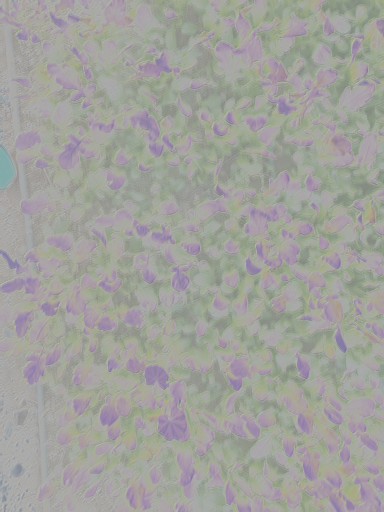

In [54]:
a = img.copy()
q = conv(a, random_kernel(seed=156), resize=512)
q